In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba

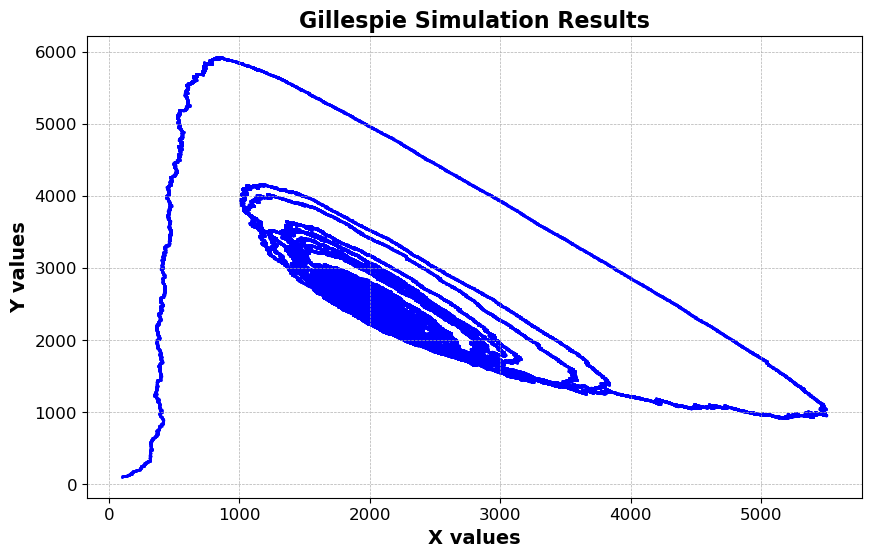

In [30]:
# parameters
VOLUME = 10e2
A = 2
B = 5

# initial state
X_INIT = 100
Y_INIT = 100
INITIAL_CONFIGURATION = np.array([X_INIT,Y_INIT])

@numba.njit
def transition_rate_vector(configuration):
    transition_rate_1 = A * VOLUME
    def transition_rate_2(x):
        return x    
    def transition_rate_3(x, y):
        return (1 / (VOLUME**2)) * x * (x - 1) * y
    def transition_rate_4(x):
        return B * x
    tmp = np.array([transition_rate_1, transition_rate_2(configuration[0]), transition_rate_3(configuration[0], configuration[1]), transition_rate_4(configuration[0])])
    return tmp

@numba.njit
def escape_rate (configuration):
    return np.sum(transition_rate_vector(configuration))

def residence_time_distribution(escape_rate, time):
    return escape_rate * np.exp(-escape_rate * time)

@numba.njit
def residence_time_cdf_inverse(escape_rate, cdf):
    return 1 / escape_rate * np.log(1 / cdf)

@numba.njit
def jump_function(old_configuration):
    rate_vector = transition_rate_vector(old_configuration)
    cumulative_sum = np.cumsum(rate_vector)
    rand = np.random.uniform(0, escape_rate(old_configuration))
    new_configuration = old_configuration.copy()

    if rand < cumulative_sum[0]: 
        new_configuration[0] += 1  # reaction 1
    elif rand < cumulative_sum[1]: 
        new_configuration[0] -= 1  # reaction 2
    elif rand < cumulative_sum[2]: 
        new_configuration[0] += 1  # reaction 3
        new_configuration[1] -= 1
    elif rand < cumulative_sum[3]: 
        new_configuration[0] -= 1  # reaction 4
        new_configuration[1] += 1

    return new_configuration

def gillespie(initial_configuration, time_max):
    time_total = 0
    configurations = [] 
    current_configuration = initial_configuration
    while time_total < time_max:
        time_total += residence_time_cdf_inverse(escape_rate(current_configuration), np.random.random())
        current_configuration = jump_function(current_configuration)
        configurations.append(current_configuration)

    return configurations    

conf = gillespie(INITIAL_CONFIGURATION, 100)

# Extract x and y values
x_values, y_values = zip(*conf)

# Plot as points with enhancements
plt.figure(figsize=(10, 6))  # Larger figure size
plt.scatter(x_values, y_values, color='blue', marker='.', s=2, alpha=0.4)  # Reduced point size and added transparency

# Add grid, labels, and title with styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("X values", fontsize=14, fontweight='bold')
plt.ylabel("Y values", fontsize=14, fontweight='bold')
plt.title("Gillespie Simulation Results", fontsize=16, fontweight='bold')

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the enhanced plot
plt.show()